In [1]:
import torch
import torchvision
import numpy as np

from coco_utils import get_coco_dataset
from transforms import ToTensor, RandomResize, CenterCrop, Compose

In [2]:
# transforms = Compose([RandomResize([640], ), CenterCrop(size=(640, 640)), ToTensor()])
transforms = Compose([ToTensor()])

dataset = get_coco_dataset(root='/Users/lvwenyu01/Desktop/workspace/dataset/coco/',
                           img_folder='train2017/',
                           ann_file='annotations/instances_train2017_rand8.json',
                           transforms=transforms)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
dataset[2][1]

{'boxes': tensor([[146.5300,   6.8200, 363.5300, 362.5200],
         [  5.6400,   3.5200, 189.5600, 287.9000],
         [ 36.8000, 293.6400, 128.8800, 458.8200],
         [  0.0000, 278.7200,  64.1900, 426.2400],
         [  0.0000, 275.9500, 375.0000, 500.0000],
         [137.7200, 182.3300, 197.1800, 288.4800]]),
 'labels': tensor([ 1,  1, 47, 47, 67, 58]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
  

In [4]:
dataset[1][1]['masks'].shape

torch.Size([2, 427, 640])

In [5]:
def show_coco(item):
    '''
    '''
    im = item[0] if isinstance(item[0], torch.Tensor) else torch.tensor(item[0])
    im = (im * 255).to(torch.uint8)
    
    anns = {k: (v if isinstance(v, torch.Tensor) else torch.tensor(v)) for k, v in item[1].items()}
    
    im = torchvision.utils.draw_bounding_boxes(im, anns['boxes'], colors='red')
    
    if 'masks' in anns:
        im = torchvision.utils.draw_segmentation_masks(im, anns['masks'].to(torch.bool), alpha=0.5)
    print(im.shape)
    
    return torchvision.transforms.ToPILImage()(im)

torch.Size([3, 480, 640])


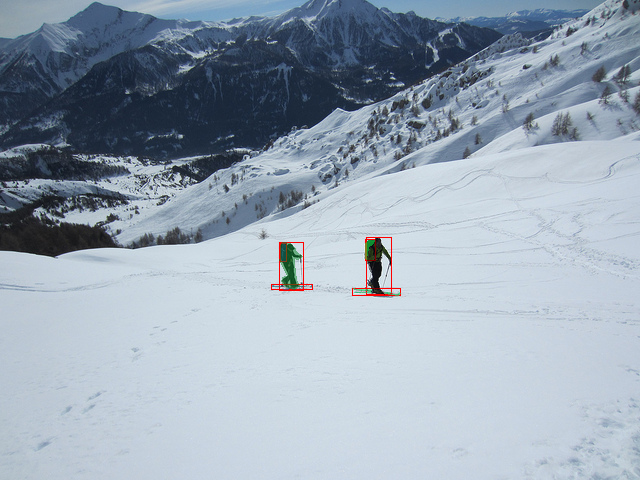

In [6]:
k = 3
show_coco(dataset[k])

In [7]:
from skimage.filters import gaussian

def image_copy_paste(img, paste_img, alpha=0.5, blend=True, sigma=1):
    if alpha is not None:
        if blend:
            alpha = gaussian(alpha, sigma=sigma, preserve_range=True)

        img_dtype = img.dtype
        alpha = alpha[..., None]
        img = paste_img * alpha + img * (1 - alpha)
        img = img.astype(img_dtype)

    return img

In [8]:
class CopyPaste(object):
    
    def __init__(self, obj_ratio=0.1, obj_min=0, obj_max=None, alpha=0.5, p=0.5):
        
        self.obj_ratio = obj_ratio
        self.obj_max = np.inf if obj_max is None else obj_max
        self.obj_min = obj_min
        
        self.p = p
    
    
    def __call__(self, item, other):
        
        if np.random.rand() > self.p:
            return item 

        image = other[0]
        masks = other[1]['masks']
        boxes = other[1]['boxes']
        labels = other[1]['labels']
        obj_total = boxes.shape[0]
        
        paste_num = np.random.randint(self.obj_min, min(self.obj_max, obj_total))

        if paste_num == 0:
            return item
    
        obj_idx = np.random.choice(range(0, obj_total), size=paste_num, replace=False)
        
        _boxes = boxes[obj_idx]
        _masks = masks[obj_idx]
        alpha = _masks.sum(dim=0) > 0
        
        
        image = self.image_copy_paste(item[0], image, alpha)
        
        target = item[1]
        target['masks'] = self.masks_copy_paste(target['masks'], _masks, alpha)
        target['boxes'] = self.boxes_copy_paste(target['boxes'], _boxes, alpha)
        
        return image, target
    
    
    @staticmethod
    def image_copy_paste(img, paste_img, alpha, blend=False, sigma=1):
        if alpha is not None:
            if blend:
                alpha = gaussian(alpha, sigma=sigma, preserve_range=True)
            
            alpha = alpha[None] * 1.0
            img = paste_img * alpha + img * (1 - alpha)

        return img

    
    @staticmethod
    def masks_copy_paste(masks, paste_masks, alpha):
        if alpha is not None:
            masks = [torch.logical_and(mask, torch.logical_xor(mask, alpha)).to(torch.uint8) for mask in masks]
            masks.extend(paste_masks)
                
        return torch.concat([m.unsqueeze(0) for m in masks], dim=0)

    
    @staticmethod
    def boxes_copy_paste(boxes, paste_boxes, alpha):
        
        return torch.concat([boxes, paste_boxes])


In [9]:
copy_paste = CopyPaste(p=1)
item = copy_paste(dataset[1], dataset[3])

show_coco(item)

RuntimeError: The size of tensor a (427) must match the size of tensor b (480) at non-singleton dimension 1

torch.Size([3, 640, 640])


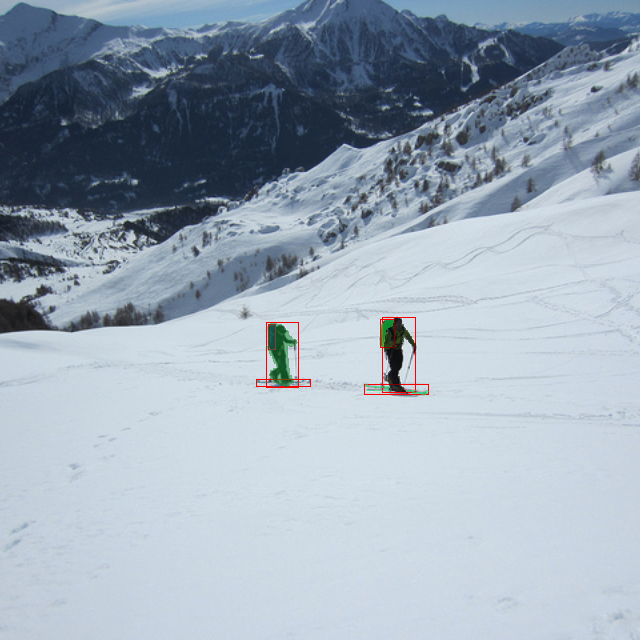

In [150]:
show_coco(dataset[3])

In [3]:
window_size = 5
shift_size = 5
h_slices = (slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None))

In [4]:
h_slices

(slice(0, -5, None), slice(-5, -5, None), slice(-5, None, None))

In [12]:
dataset[0]

(tensor([[[0.5961, 0.5961, 0.6000,  ..., 0.6275, 0.6275, 0.6275],
          [0.5961, 0.5961, 0.6000,  ..., 0.6314, 0.6314, 0.6314],
          [0.6000, 0.6000, 0.6039,  ..., 0.6314, 0.6314, 0.6314],
          ...,
          [0.7176, 0.7176, 0.7176,  ..., 0.6902, 0.6784, 0.6706],
          [0.7294, 0.7333, 0.7333,  ..., 0.6941, 0.6824, 0.6667],
          [0.7255, 0.7294, 0.7294,  ..., 0.6706, 0.6431, 0.6235]],
 
         [[0.6510, 0.6510, 0.6549,  ..., 0.6745, 0.6745, 0.6745],
          [0.6510, 0.6510, 0.6549,  ..., 0.6784, 0.6784, 0.6784],
          [0.6549, 0.6549, 0.6588,  ..., 0.6784, 0.6784, 0.6784],
          ...,
          [0.6275, 0.6275, 0.6275,  ..., 0.6078, 0.5961, 0.5882],
          [0.6392, 0.6431, 0.6431,  ..., 0.6118, 0.6000, 0.5843],
          [0.6353, 0.6392, 0.6392,  ..., 0.5882, 0.5608, 0.5412]],
 
         [[0.7569, 0.7569, 0.7608,  ..., 0.7765, 0.7765, 0.7765],
          [0.7569, 0.7569, 0.7608,  ..., 0.7804, 0.7804, 0.7804],
          [0.7608, 0.7608, 0.7647,  ...,

In [10]:
import instaboostfast as instaboost
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np

root = '/Users/lvwenyu01/Desktop/workspace/dataset/coco'
img_folder = 'train2017' 

# https://github.com/GothicAi/InstaBoost-pypi
coco = COCO(os.path.join(root, 'annotations', 'instances_train2017_rand8.json'))
img_ids = sorted(coco.getImgIds())
print(img_ids)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[162032, 213399, 229362, 266697, 363119, 419087, 509149, 567439]


torch.Size([3, 500, 375])


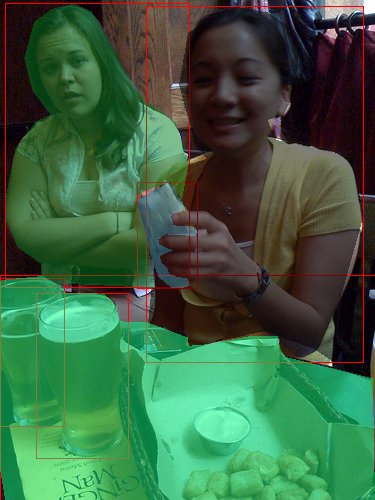

In [25]:
show_coco(dataset[2])

In [30]:
# https://github.com/GothicAi/Instaboost/blob/master/mmdetection/mmdet/datasets/coco.py

def _parse_ann_info(ann_info, with_mask=True):
    """Parse bbox and mask annotation.
    Args:
        ann_info (list[dict]): Annotation info of an image.
        with_mask (bool): Whether to parse mask annotations.
    Returns:
        dict: A dict containing the following keys: bboxes, bboxes_ignore,
            labels, masks, mask_polys, poly_lens.
    """
    gt_bboxes = []
    gt_labels = []
    gt_bboxes_ignore = []
    # Two formats are provided.
    # 1. mask: a binary map of the same size of the image.
    # 2. polys: each mask consists of one or several polys, each poly is a
    # list of float.
    if with_mask:
        gt_masks = []
        gt_mask_polys = []
        gt_poly_lens = []
        
    for i, ann in enumerate(ann_info):
        if ann.get('ignore', False):
            continue
            
        x1, y1, w, h = ann['bbox']
        if ann['area'] <= 0 or w < 1 or h < 1:
            continue
            
        bbox = [x1, y1, x1 + w - 1, y1 + h - 1]
        
        if ann['iscrowd']:
            gt_bboxes_ignore.append(bbox)
        else:
            gt_bboxes.append(bbox)
            gt_labels.append(ann['category_id'])

        if with_mask:
            gt_masks.append(coco.annToMask(ann))
            mask_polys = [
                p for p in ann['segmentation'] if len(p) >= 6
            ]  # valid polygons have >= 3 points (6 coordinates)
            poly_lens = [len(p) for p in mask_polys]
            gt_mask_polys.append(mask_polys)
            gt_poly_lens.extend(poly_lens)
            
    if gt_bboxes:
        gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
        gt_labels = np.array(gt_labels, dtype=np.int64)
        
    else:
        gt_bboxes = np.zeros((0, 4), dtype=np.float32)
        gt_labels = np.array([], dtype=np.int64)

    if gt_bboxes_ignore:
        gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
    else:
        gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

    ann = dict(boxes=gt_bboxes, labels=gt_labels, bboxes_ignore=gt_bboxes_ignore)

    if with_mask:
        ann['masks'] = np.array(gt_masks)
        # ann['mask_polys'] = gt_mask_polys
        # ann['poly_lens'] = gt_poly_lens
        assert len(gt_bboxes) == len(gt_labels) == len(gt_masks), ''
        
        # print(gt_mask_polys)
        
        _mask = np.array(gt_masks).sum(axis=0)
        _mask = _mask <= 1
        
        # Image.fromarray(_mask).show()
        
        # for m in gt_masks:
        #     Image.fromarray(m * 255).show()

        
        # _mask = np.max(_mask) <= 1
        # gt_masks = [np.logical_and(mask, np.logical_xor(mask, alpha)) for mask in gt_masks]
        # print(_mask)
        # gt_masks = [np.logical_and(mask, np.logical_xor(mask, alpha)) for mask in gt_masks]
        
        segment = np.ones_like(_mask) * 255
        print(segment.shape)
        
        for msk, lab in zip(gt_masks, gt_labels):
            segment[msk>0] = lab
        
        # segment = np.ones_like(_mask) * 255
        # segment = [msk.astype(np.float32) * lab for msk, lab in zip(gt_masks, gt_labels)] + [segment, ]
        # segment = np.array(segment).sum(axis=0).astype(np.uint8)
        
        Image.fromarray(segment.astype(np.uint8)).show()
        
    return ann


000000229362.jpg
(500, 375)
(6, 500, 375)
torch.Size([3, 500, 375])


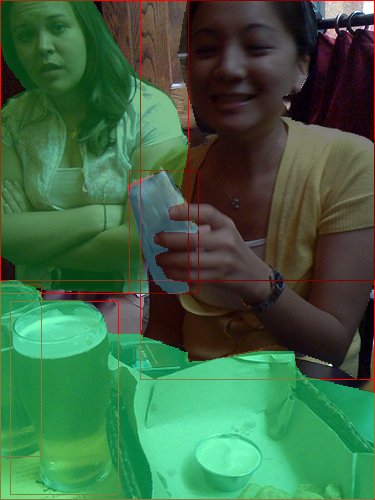

In [31]:
def aug(idx):
    img_id = img_ids[idx]
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    ann_info = coco.loadAnns(ann_ids)
    
    img_anno = coco.loadImgs([img_id])[0]
    im_fname = img_anno['file_name']
    print(im_fname)
    im_fpath = os.path.join(root, img_folder, im_fname)
    im = np.array(Image.open(im_fpath))
    # Image.open(im_fpath).show()
    
    cfg = instaboost.InstaBoostConfig()    
    ann_info, img = instaboost.get_new_data(ann_info, im, cfg, background=None)
    
#     _m = ann_info['semantic'] != 255
#     sample['semantic'][_m] = ann_info['semantic']
#     Image.fromarray(segment.astype(np.uint8)).show()

    ann_info = _parse_ann_info(ann_info)
    
    print(ann_info['masks'].shape)
    # print(ann_info)
    img = img.transpose(2, 0, 1).astype(np.uint8) / 255.
    
    return img, ann_info

show_coco(aug(2))